In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
import re
sns.set_style("darkgrid")
sns.color_palette("mako", as_cmap=True)
import warnings
warnings.filterwarnings('ignore')


In [2]:
df= pd.read_csv("train.csv")

## 1. Getting glimpse of data

In [3]:
df.reset_index(drop=True, inplace=True)
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233154 entries, 0 to 233153
Data columns (total 41 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   UniqueID                             233154 non-null  int64  
 1   disbursed_amount                     233154 non-null  int64  
 2   asset_cost                           233154 non-null  int64  
 3   ltv                                  233154 non-null  float64
 4   branch_id                            233154 non-null  int64  
 5   supplier_id                          233154 non-null  int64  
 6   manufacturer_id                      233154 non-null  int64  
 7   Current_pincode_ID                   233154 non-null  int64  
 8   Date.of.Birth                        233154 non-null  object 
 9   Employment.Type                      225493 non-null  object 
 10  DisbursalDate                        233154 non-null  object 
 11  State_ID     

The above information says that we have 1 column with datatype as float, 34 columns as int and 6 columns as object. We can clearly see the datatypes of many columns are not correct so we change the datatype of such columns

## 2. Data preprocessing 

In [5]:
for col in ['UniqueID','branch_id','supplier_id','manufacturer_id','Current_pincode_ID','State_ID',
           'Employee_code_ID','MobileNo_Avl_Flag','Aadhar_flag','PAN_flag','VoterID_flag','Driving_flag','Passport_flag','loan_default']:
    df[col] = df[col].astype('category')

 Here we have converted most of the columns into correct datatypes like branch_id,supplier_id,manufacturer_id,Current_pincode_ID,State_ID, Employee_code_ID, MobileNo_Avl_Flag, Aadhar_flag, PAN_flag, VoterID_flag, Driving_flag, Passport_flag into category datatype

Now changing the datatype of DisbursalDate, Date.of.Birth , AVERAGE.ACCT.AGE, CREDIT.HISTORY.LENGTH columns

In [6]:
df['DisbursalDate']= pd.to_datetime(df['DisbursalDate'])
df['Date.of.Birth']= pd.to_datetime(df['Date.of.Birth'])

Converting date.of.Birth to age

In [7]:
import datetime
def from_dob_to_age(born):
    today = datetime.date.today()
    return abs(today.year - born.year - ((today.month, today.day) < (born.month, born.day)))
df['Date.of.Birth']=df['Date.of.Birth'].apply(lambda x: from_dob_to_age(x))
df['DisbursalDate']=df['DisbursalDate'].apply(lambda x: from_dob_to_age(x))

Changing the column names to Age.of.Customer and Disbursal.Age

In [8]:
df=df.rename(columns={"Date.of.Birth": "Age.of.Customer", "DisbursalDate": "Disbursal.Age"})

In [9]:
def toMonths(str):
    cache = []
    for k in df[str]:
        temp = int(re.split("[yrs mon]+", k)[0]) * 12 + int(re.split("[yrs mon]+", k)[1])
        cache.append(temp)
    return cache

In [10]:
# Converting years and months to number of months
df['CREDIT.HISTORY.LENGTH'] = toMonths('CREDIT.HISTORY.LENGTH')
df['AVERAGE.ACCT.AGE'] = toMonths('AVERAGE.ACCT.AGE')

Since we have converted most of the columns to correct datatype we now move to the "PERFORM_CNS.SCORE.DESCRIPTION " column where we have too may object values and we need to handle them

<AxesSubplot:>

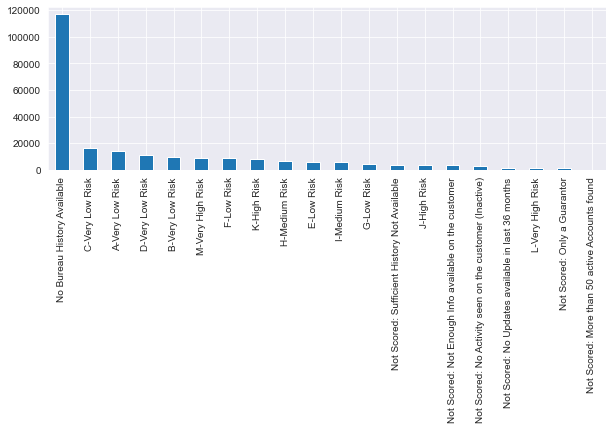

In [11]:
df['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts().plot(kind="bar",figsize=(10,3))

Here we can see we have many categories we can now combine them to make only 5 categories

0. Very low risk
1. low risk
2. medium risk 
3. high risk
4. Very high risk
5. Not scored

In [12]:
# Very low risk
df['PERFORM_CNS.SCORE.DESCRIPTION'].replace({"C-Very Low Risk": 0, "A-Very Low Risk": 0,"D-Very Low Risk":0,"B-Very Low Risk":0}, inplace=True)
# Low Risk
df['PERFORM_CNS.SCORE.DESCRIPTION'].replace({"F-Low Risk": 1, "E-Low Risk": 1,"G-Low Risk":1}, inplace=True)
# medium risk
df['PERFORM_CNS.SCORE.DESCRIPTION'].replace({"H-Medium Risk": 2, "I-Medium Risk": 2}, inplace=True)
# High risk
df['PERFORM_CNS.SCORE.DESCRIPTION'].replace({"J-High Risk": 3, "K-High Risk": 3}, inplace=True)
#Very high risk
df['PERFORM_CNS.SCORE.DESCRIPTION'].replace({"L-Very High Risk": 4, "M-Very High Risk": 4}, inplace=True)
# Not scored
df['PERFORM_CNS.SCORE.DESCRIPTION'].replace({"No Bureau History Available": 5, 
                                             "Not Scored: Sufficient History Not Available": 5,
                                             "Not Scored: Not Enough Info available on the customer":5,
                                             "Not Scored: No Activity seen on the customer (Inactive)":5,
                                             "Not Scored: No Updates available in last 36 months":5,
                                             "Not Scored: Only a Guarantor":5,
                                             "Not Scored: More than 50 active Accounts found":5}, inplace=True)
# finally converting the column to category
df['PERFORM_CNS.SCORE.DESCRIPTION'] = df['PERFORM_CNS.SCORE.DESCRIPTION'].astype('category')

In [13]:
df['PERFORM_CNS.SCORE.DESCRIPTION'].value_counts(sort=False)

0     50728
1     18294
2     12412
3     12025
4      9910
5    129785
Name: PERFORM_CNS.SCORE.DESCRIPTION, dtype: int64

Now the only untreated column is the Employment_type. But before that we need to check if our data has any null values

# 3. EDA

### 3.1  Checking and Visualising the missing values

<AxesSubplot:>

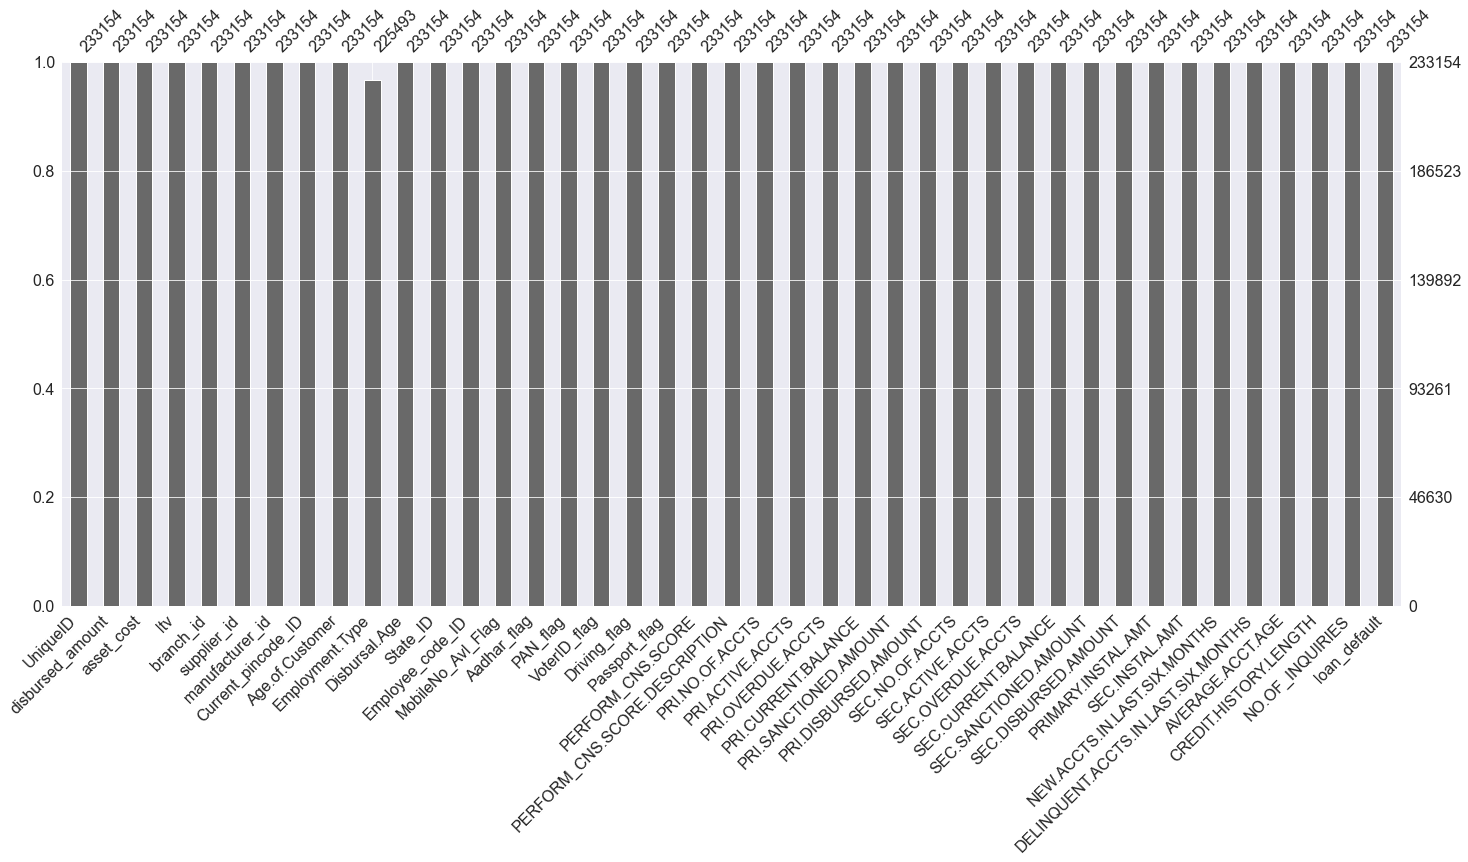

In [14]:
msno.bar(df)

The above barplot shows the Employment_type column has missing values. Since the dataset has 233154 datapoints the columns having less than 233154 have missing values. To handle this we will replace the null values with a different category.

<AxesSubplot:>

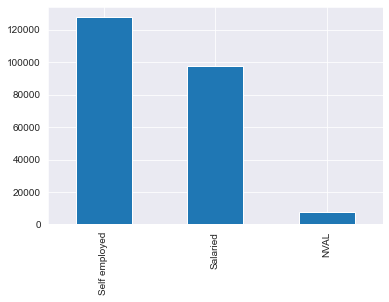

In [15]:
df['Employment.Type']=df['Employment.Type'].fillna("NVAL")
df['Employment.Type']=df['Employment.Type'].astype("category")
df['Employment.Type'].value_counts().plot(kind='bar')

 Hence we have filled the missing values with "Nval" and converted the datatype of the 'Employment.Type' column to category.

Converting the Employment.Type Categories

In [16]:
df['Employment.Type']= df['Employment.Type'].cat.codes
df['Employment.Type'].value_counts()

2    127635
1     97858
0      7661
Name: Employment.Type, dtype: int64

2-SelfEmployed

1- Salaried

0- Nval

###### Calculating how many unique values a category has

In [17]:
df.select_dtypes(include=['category']).nunique()

UniqueID                         233154
branch_id                            82
supplier_id                        2953
manufacturer_id                      11
Current_pincode_ID                 6698
State_ID                             22
Employee_code_ID                   3270
MobileNo_Avl_Flag                     1
Aadhar_flag                           2
PAN_flag                              2
VoterID_flag                          2
Driving_flag                          2
Passport_flag                         2
PERFORM_CNS.SCORE.DESCRIPTION         6
loan_default                          2
dtype: int64

1. Dropping the columns having more unique ids as they may introduce noise. 
2. MobileNo_Avl_Flag has only one category so we can drop that column as well

In [18]:
df=df.drop(['supplier_id','Current_pincode_ID','Employee_code_ID','State_ID','MobileNo_Avl_Flag'],axis=1)

### 3.2 Univariate analysis

 Univariate analysis is also used to highlight missing and outlier values.
 
 First perform univariate analysis on the numerical data 

###### Function for plotting bar and hisogram

In [19]:
import matplotlib.pyplot as plt
import matplotlib as mpl
sns.set(color_codes=True)


def BarPlot(x):
    sns.countplot(df[x],palette='muted')
    plt.title(x, fontsize=20)
    
    
def Box_hist_plot(x):
    f,(ax_box,ax_hist)=plt.subplots(2,sharex=True,
                                   gridspec_kw={"height_ratios":(.15,.85)})
    sns.boxplot(x,ax=ax_box,color='red')
    sns.distplot(x,ax=ax_hist,color='green')
    
    ax_box.set(yticks=[])
    sns.distplot(ax=ax_hist)
    sns.distplot(ax=ax_box)
    plt.show

###### Plotting account related data

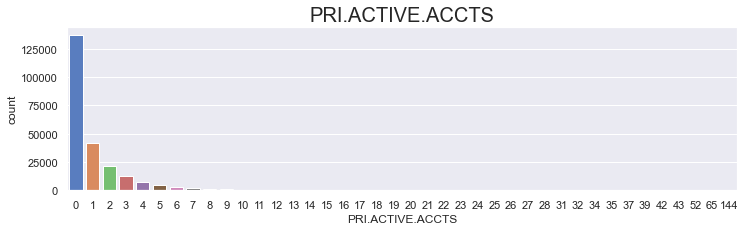

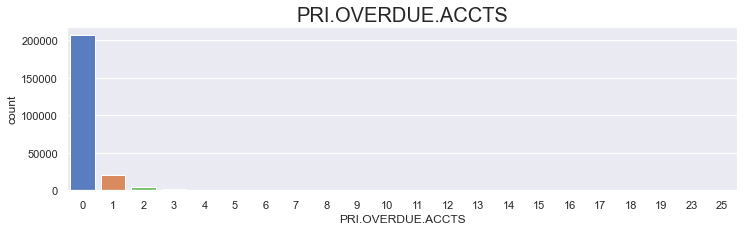

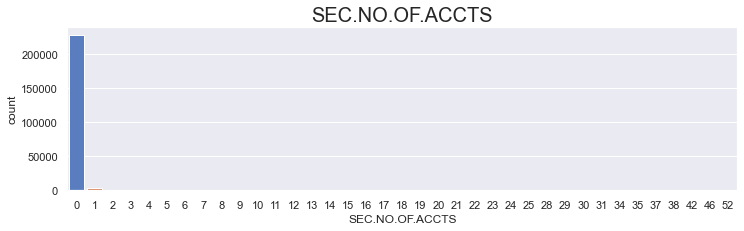

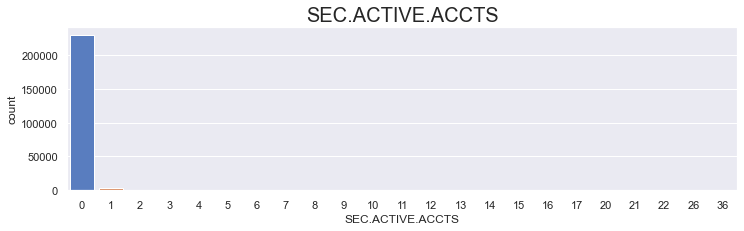

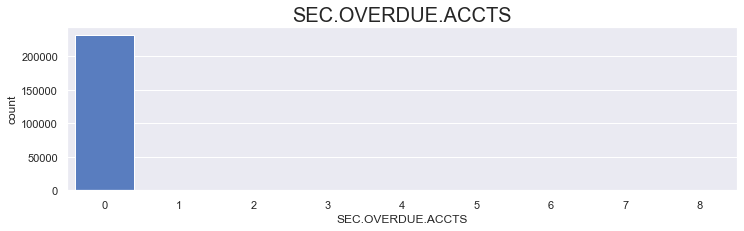

In [20]:
i=1
for col in ['PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'SEC.NO.OF.ACCTS',
       'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS']:
    plt.figure(figsize=(12,3))
    plt.title("Figure"+str(i)+"Bar chart of"+col,fontsize=12)
    BarPlot(col)
    plt.show()
    i=i+1

The above graphs show the number of active and overdue loan accounts of the customers

###### More important information about the accounts

<Figure size 432x288 with 0 Axes>

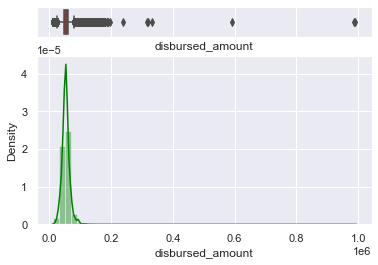

<Figure size 432x288 with 0 Axes>

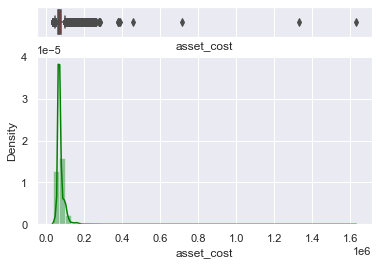

<Figure size 432x288 with 0 Axes>

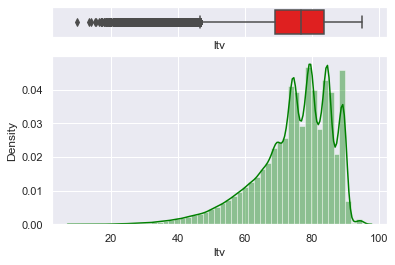

<Figure size 432x288 with 0 Axes>

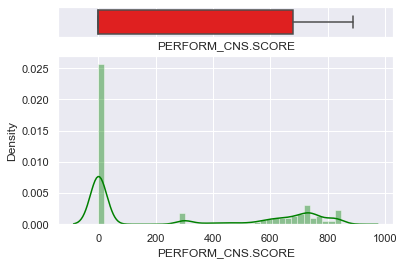

<Figure size 432x288 with 0 Axes>

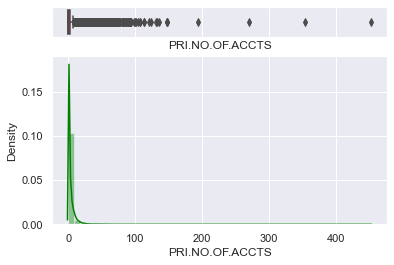

<Figure size 432x288 with 0 Axes>

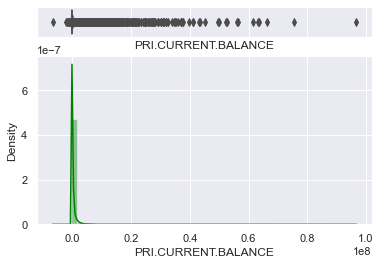

<Figure size 432x288 with 0 Axes>

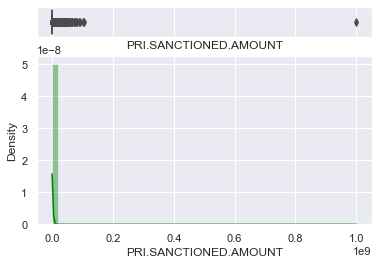

<Figure size 432x288 with 0 Axes>

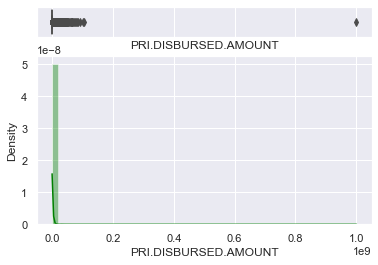

<Figure size 432x288 with 0 Axes>

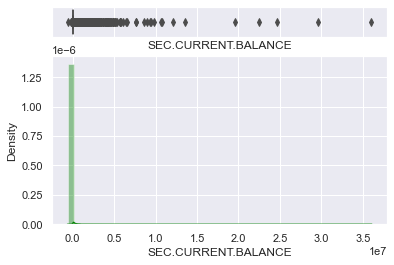

<Figure size 432x288 with 0 Axes>

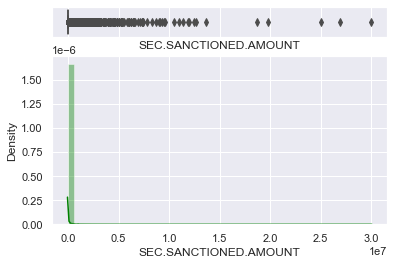

<Figure size 432x288 with 0 Axes>

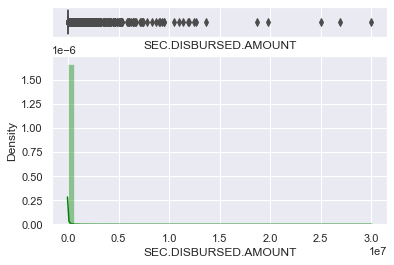

<Figure size 432x288 with 0 Axes>

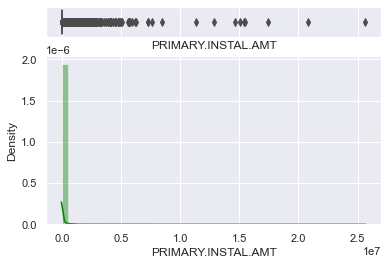

<Figure size 432x288 with 0 Axes>

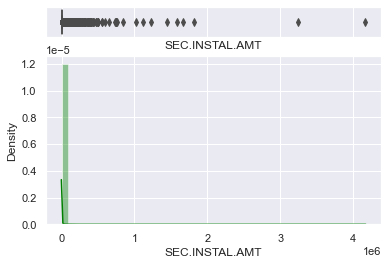

<Figure size 432x288 with 0 Axes>

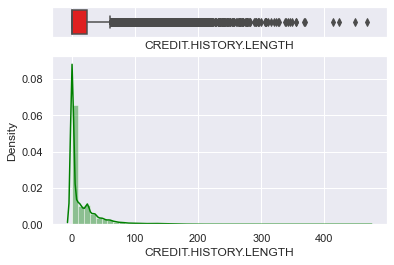

<Figure size 432x288 with 0 Axes>

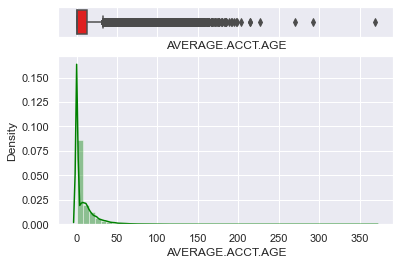

In [21]:
i=1
for col in ['disbursed_amount', 'asset_cost', 'ltv', 'PERFORM_CNS.SCORE', 'PRI.NO.OF.ACCTS', 'PRI.CURRENT.BALANCE',
       'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT','SEC.CURRENT.BALANCE',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'SEC.INSTAL.AMT','CREDIT.HISTORY.LENGTH','AVERAGE.ACCT.AGE']:
    plt.suptitle("figure"+str(i)+"Histogram and Boxplot of"+col)
    Box_hist_plot(df[col])
    plt.show()
    i=i+1

1. The histogram of disbursed_amount and asset cost shows that it is approximately normally distributed and the boxplot shows that there are some outliers present.
Mean of Disbursed amount=54356.99
Mean of Asset_cost=75865.06

2. LTV has some spikes with mean 74.7
3. Large portion of PERFORM_CNS.SCORE falls on 0 and mean is around 289.46 
4. Credit history length and the Average-Acc.Age have skew towards right 
4. Rest of the attributes have majority of values near to zero

###### Plotting the age

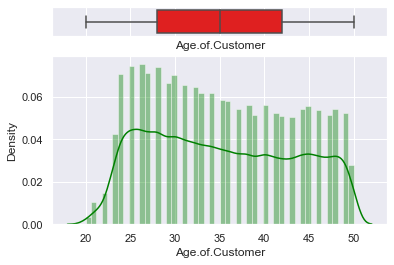

In [22]:
Box_hist_plot(df['Age.of.Customer'])

Here we can see that people in the age group of 25-50 take loans

###### Plotting lesser important data and the categorical variables

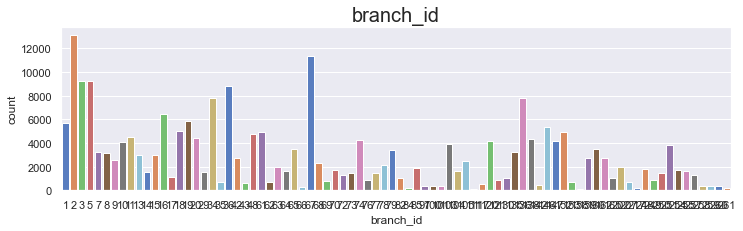

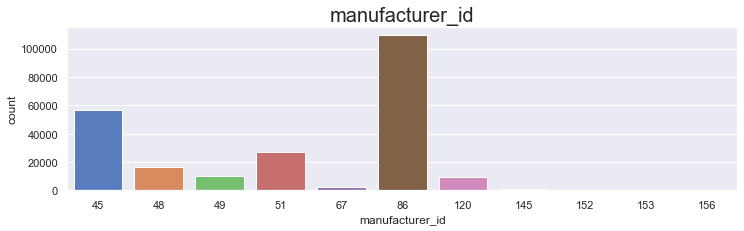

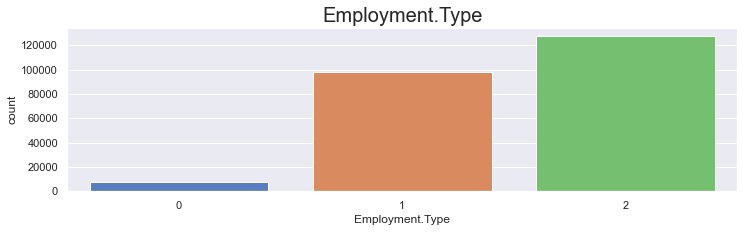

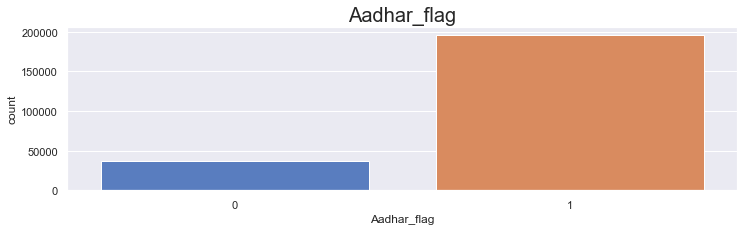

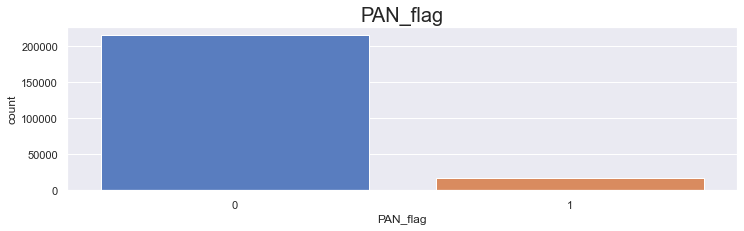

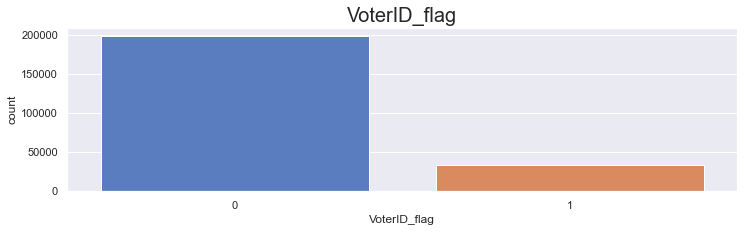

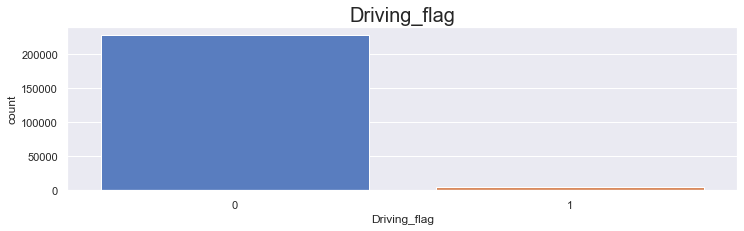

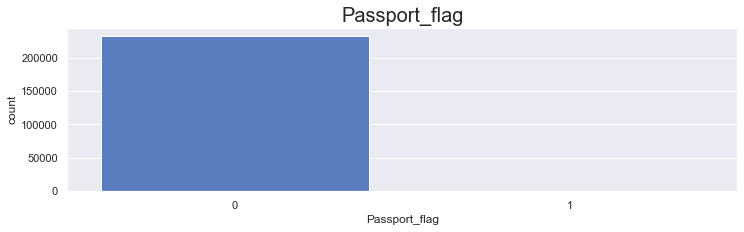

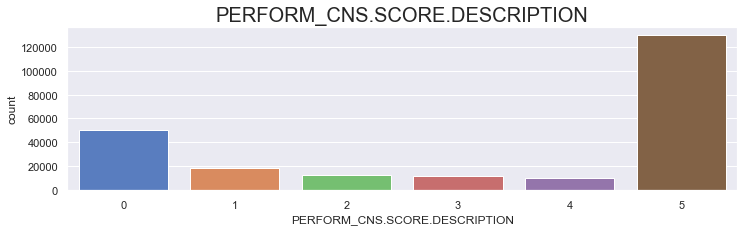

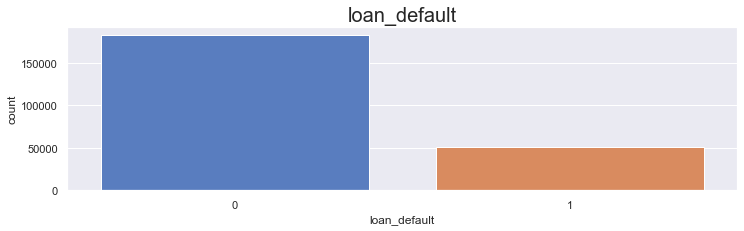

In [23]:
i=1
for col in ['branch_id', 'manufacturer_id', 'Employment.Type', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag',
       'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE.DESCRIPTION',
       'loan_default']:
    plt.figure(figsize=(12,3))
    plt.title("Figure"+str(i)+"Bar chart of"+col,fontsize=12)
    BarPlot(col)
    plt.show()
    i=i+1

1. The columns Aadhar_Flag, Pan Flag, VoterID_flag, driving_flag, Passport_flag are imbalanced.
2. the loan default column is also highle imbalnced which makes our dataset imbalanced. Hence actions should be taken to overcome this prolem

### 3.3 Multivariate analysis

###### Histogram of Numerical features against loan_default

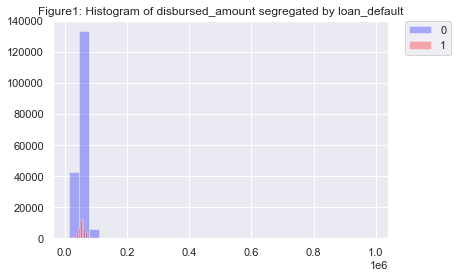

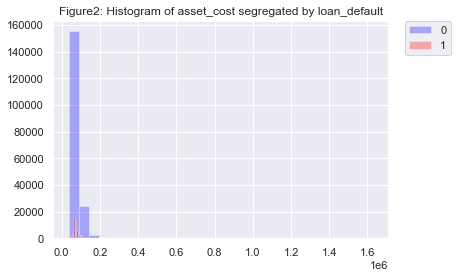

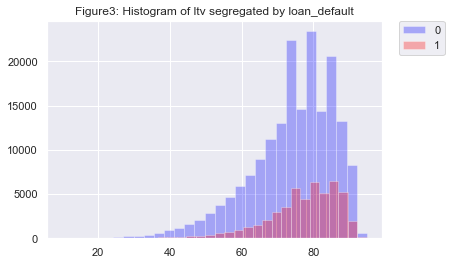

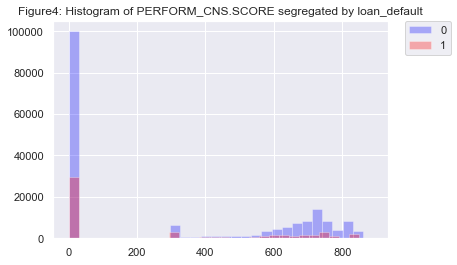

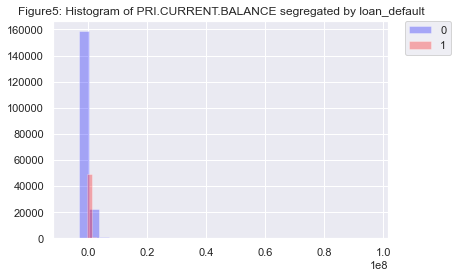

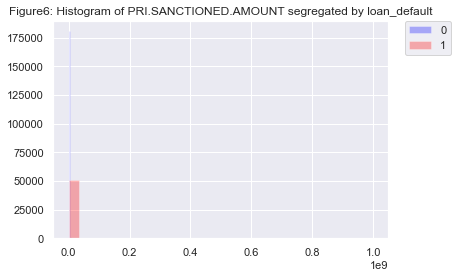

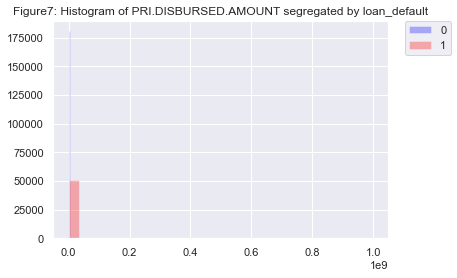

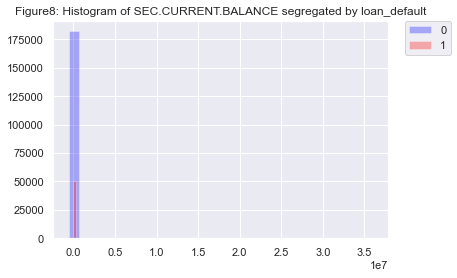

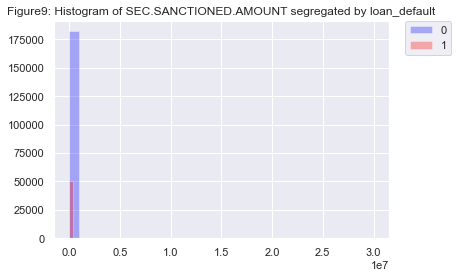

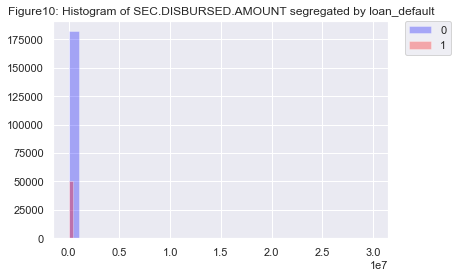

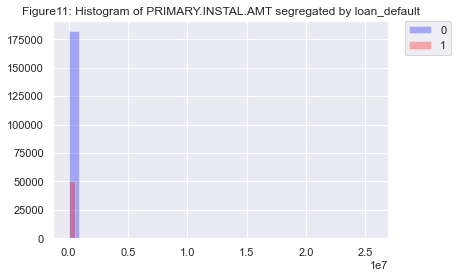

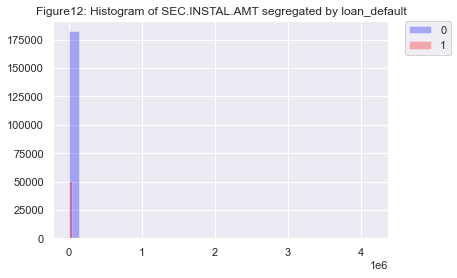

In [24]:
i=1
for col in ['disbursed_amount','asset_cost','ltv','PERFORM_CNS.SCORE',
           'PRI.CURRENT.BALANCE','PRI.SANCTIONED.AMOUNT','PRI.DISBURSED.AMOUNT',
           'SEC.CURRENT.BALANCE',
       'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT',
       'SEC.INSTAL.AMT']:
    df1=df.loc[df['loan_default']==0,col]
    df2=df.loc[df['loan_default']==1,col]
    
    plt.hist(df1,alpha=0.3,bins=30,color='blue')
    plt.hist(df2,alpha=0.3,bins=30,color='red')
    plt.title("Figure"+str(i)+": Histogram of "+col+" segregated by loan_default")
    i=i+1
    plt.legend(df['loan_default'].unique(), bbox_to_anchor=(1.05,1),loc=2,borderaxespad=0.)
    plt.show()

1. These are the histograms for each continuous variable. It depicts lower disbursement amount and lower asset cost tends to have lower chances of payment default
2. Higher ltv has more chances of Payment defaults

###### Barplot of categorical features against loan_default

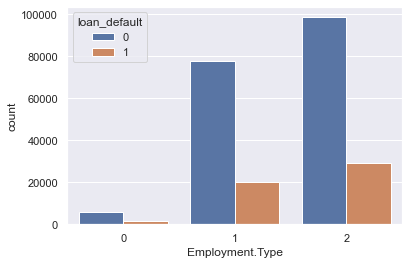

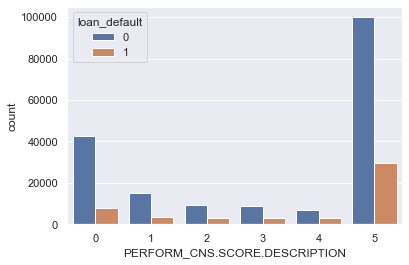

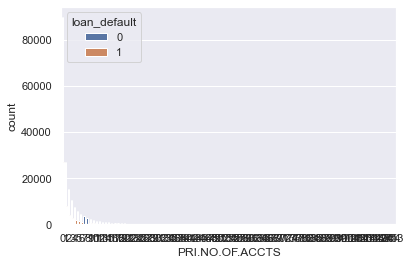

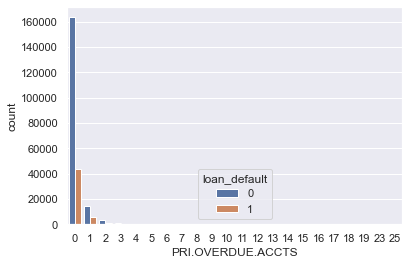

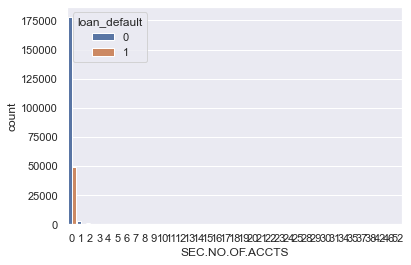

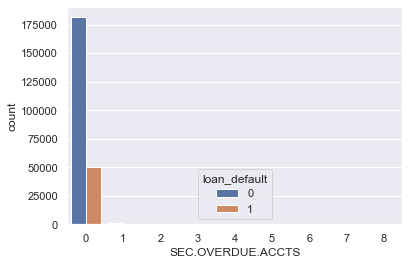

In [25]:
i=1
for col in ['Employment.Type','PERFORM_CNS.SCORE.DESCRIPTION','PRI.NO.OF.ACCTS','PRI.OVERDUE.ACCTS','SEC.NO.OF.ACCTS','SEC.OVERDUE.ACCTS']:
    sns.countplot(x=col,hue='loan_default',data=df)
    plt.show()
    

The above data shows 

1. The self_employed people have high tendency for payment defaults
2. people in the category 5 in perform.CNS.Score.Description also have high tendency for payment defaults
3. people with more primary overdue accts also have more tendency to default payment

# 4.Feature Selection and Feature Engineering

###### Correlation Matrix of numerical Features

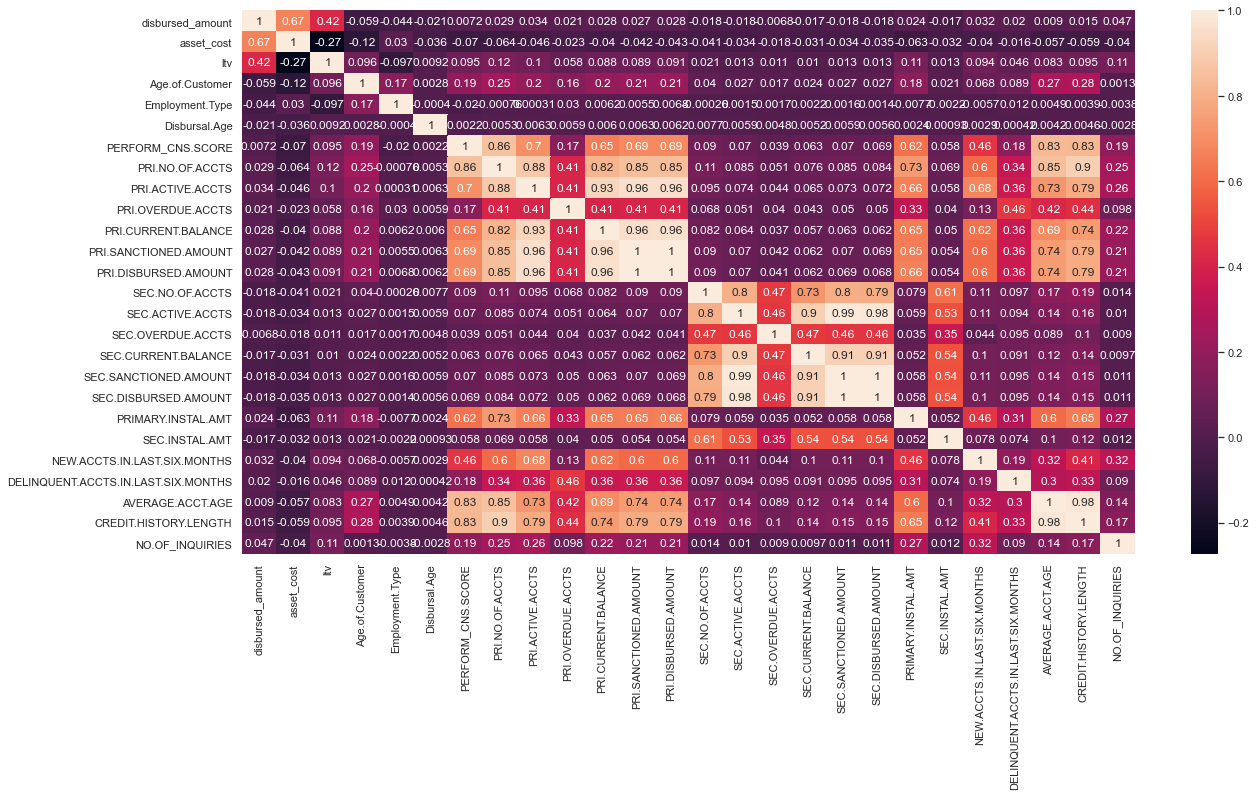

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
corrMatrix = df.corr(method='spearman')
sns.heatmap(corrMatrix, annot=True)
plt.show()

1. Disbursed_Amount and Asset amout are correlated   0.75
2. PRI.Active.Accts and Pri.No.accts are correlated  0.75
3. Sec.No.Accts and Sec.Active accts are correlated  0.83
4. Sec.Current.Balance and Sec.sanctioned.amount are correlated  0.93
5. Credit.history.length and average account age are correlated  0.83

Hence we can delete the columns which are highly correlated and keep only the ones required. This will simplify the problem.

In [27]:
df=df.drop(['UniqueID','PRI.ACTIVE.ACCTS','SEC.ACTIVE.ACCTS','SEC.CURRENT.BALANCE','AVERAGE.ACCT.AGE'],axis=1)

With tests it was found that further dimensionality reduction hampers the accuracy of the algorithm

In [28]:
df['branch_id']= df['branch_id'].cat.codes
df['manufacturer_id']= df['manufacturer_id'].cat.codes
df['Aadhar_flag']= df['Aadhar_flag'].cat.codes
df['PAN_flag']= df['PAN_flag'].cat.codes
df['VoterID_flag']= df['VoterID_flag'].cat.codes
df['Driving_flag']= df['Driving_flag'].cat.codes
df['Passport_flag']= df['Passport_flag'].cat.codes
df['PERFORM_CNS.SCORE.DESCRIPTION']= df['PERFORM_CNS.SCORE.DESCRIPTION'].cat.codes


# 5.Splitting the data and oversampling 

Since the dataset is highly imbalanced oversampling can be used to balance the dataset

In [29]:
x=df.drop(['loan_default'],axis=1)
y=df['loan_default']

from imblearn.over_sampling import SMOTE
X_train, Y_train = SMOTE().fit_sample(x, y.values.ravel())



from sklearn.model_selection import train_test_split
x_train,x_test, y_train,y_test=train_test_split(X_train,Y_train,test_size=0.30,random_state=0)

Using TensorFlow backend.


# 6. Applying Random Forest algorithm

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
classifier= RandomForestClassifier()
classifier.fit(x_train,y_train)
Y_pred = classifier.predict(x_test)
print("Train Accuracy: ", classifier.score(x_train, y_train))
print("Validation Accuracy: ", classifier.score(x_test,y_test))
print("AUROC Score of Random Forest = ", roc_auc_score(y_test, Y_pred))

Train Accuracy:  0.9994365315385819
Validation Accuracy:  0.8025674269123313
AUROC Score of Random Forest =  0.8023982168603164


In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.77      0.86      0.81     54923
           1       0.84      0.74      0.79     54603

    accuracy                           0.80    109526
   macro avg       0.81      0.80      0.80    109526
weighted avg       0.81      0.80      0.80    109526



## Hence this model has an accuracy of 80%. We observed that there were outliers in some of the numerical columns but they were left untreated because random forest algorithm handles outliers.

The accuracy given by other classification algorithms are
1. Logistic Regression- 56%
2. Xgboost- 73%
3. Decision Tress- 75%
4. GradientBoosting-73%

After preprocessing the test_data as similar to the train_data we can now apply it to classifier

<AxesSubplot:xlabel='Loan_Default', ylabel='Count'>

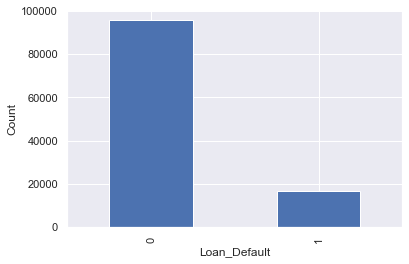

In [32]:
test_data=pd.read_csv("test_preprocessed.csv")
test_data.head()
test_data.drop(['Unnamed: 0'],axis=1,inplace=True)
test_Y_RF = classifier.predict(test_data)
test=pd.read_csv("test.csv")
test['loan_default']=test_Y_RF
test['loan_default'].value_counts().plot(kind='bar',xlabel='Loan_Default',ylabel="Count")

In [33]:
test_new=test[['UniqueID','loan_default']]
test_new = test_new[test_new['loan_default'] == 1] 
test_new.head()

,UniqueID,loan_default
6,708592,1
8,712795,1
11,753695,1
12,708646,1
14,714877,1


# Hence we have the Unique id of all the possible loan_defaults